# Business Analytics and Applications - Midterm Project
**By Nam Jin Kang 2015310937**

In this notebook I will be taking a look at are "🏀 2020 March Madness Data - First Look EDA" and "Redefining NCAA Basketball Positions using Data!" by user 'Rob Mulla'. The first notebook a look at historical data accumulated throughout the years on everything from player by player statistics, team results. The second notebook uses unsupervised machine learning to cluster NCAA players into different player types. These notebook was a submission for a competition held by Google and the NCAA (National Collegiate Athletic Association).

The reason I've decided to combine the two notebooks is because they can work off of each other to provide us with very interesting analysis into the NCAA and it's players. 

I will be breaking down and paraphrasing the analysis he conducted by using what we learned in class, testing out his code and analysis, then expressing my thoughts on his method of analysis. 

I am in no way experienced with python and some of the more technical aspects are still out of my depth, but I will try my best to do an accurate, informative breakdown of this procedure and code.


![](https://upload.wikimedia.org/wikipedia/en/thumb/2/28/March_Madness_logo.svg/440px-March_Madness_logo.svg.png) 


## Importing Libraries 
First we start off by importing all the necessary libraries for the analysis. I will quickly breakdown these libraries and what each of them do. 
**Pandas** is a python library used for data manipulation and data analysis, and is especially useful for manipulating tables and managing time series. 
**Numpy** is a python library that adds a lot of functionality for managing arrays and matrices. It also enables the user to use very complex mathematical functions
**Matplotlib** is used for visualizing data. It has many useful tools to make graphs and plots. 
**Seaborn** is also a library that focuses on data visualization, and is actually based on matplotlib. 
**os** and **gc**, which represents "miscellaneous operating system interfaces" and "garbage collector", is used for background tasks that is not relevant to the analysis itself. 



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
import seaborn as sns
plt.style.use('seaborn-dark-palette')
mypal = plt.rcParams['axes.prop_cycle'].by_key()['color'] # Grab the color pal
import os
import gc

MENS_DIR = '../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament'
WOMENS_DIR = '../input/google-cloud-ncaa-march-madness-2020-division-1-womens-tournament'

## Log Loss 
This competition scores it's submissions using something called the **"Log Loss Metric".** 

This is the equation that defines Log Loss, and is provided by Google for competition participants to use:

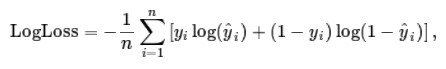

where:

n is the number of games played

\\( \hat{y}_i \\) is the predicted probability of team 1 beating team 2

\\( y_i \\) is 1 if team 1 wins, 0 if team 2 wins

\\( log() \\) is the natural (base e) logarithm

-----------------------------------------------

In essence, this metric is used to punish overly confident and wrong predictions by more severly punishing your score based on how certain your prediction probability is. Meaning, assuming that you got the prediction wrong, you are more severly punished if you had predicted that there was a 0.8 chance vs. a 0.3 chance.


In [ ]:
def logloss(true_label, predicted, eps=1e-15):
    p = np.clip(predicted, eps, 1 - eps)
    if true_label == 1:
        return -np.log(p)
    return -np.log(1 - p)

In [ ]:
print(f'Confident Wrong Prediction: \t\t {logloss(1, 0.01):0.4f}')
print(f'Confident Correct Prediction: \t\t {logloss(0, 0.01):0.4f}')
print(f'Non-Confident Wrong Prediction: \t {logloss(1, 0.49):0.4f}')
print(f'Non-Confident Correct Prediction: \t {logloss(0, 0.49):0.4f}')

## Sample Submission
These are the samples that will be used by this notebook. 

As you can see, there are 2 different samples, 1 for the mens league and another for the womens league.


In [ ]:
Mss = pd.read_csv(f'{MENS_DIR}/MSampleSubmissionStage1_2020.csv')
Wss = pd.read_csv(f'{WOMENS_DIR}/WSampleSubmissionStage1_2020.csv')
Mss.head()

## Team Data
From the data sets, we can see the unique team ID, team name, 1st year they  participated in Division 1 League(D1), and last year they participated in D1 League. 

Because there are 2 seperate datasets for male and female leagues, there are 2 tables, and as you can see, the newest team to start playing in Division 1 is Merrimack (Team ID: 1467). However the female league data does not contain information on when they first and last played in the D1 League.

In [ ]:
MTeams = pd.read_csv(f'{MENS_DIR}/MDataFiles_Stage1/MTeams.csv')
MTeams.sort_values('FirstD1Season', ascending=False).head(5)

In [ ]:
WTeams = pd.read_csv(f'{WOMENS_DIR}/WDataFiles_Stage1/WTeams.csv')
WTeams.head()

## Seasons Data
### MSeasons.csv & WSeasons.csv

The M and F Seasons.csv includes historical data about the properties of a season. Meaning it has details on when the season started (year and date), and contains **nominal data** about which region is designated which alphabet (W, X, Y, Z). I believe it would have been less confusing down the road and a better form of data preparation if the regions were designated N, W, S, E labels instead. Later in this notebook, they use these labels in distinguishing different teams seeds. So for example, East region's number 1 seed team being W1. I feel it would have been less confusing if it was labeled E1 instead(E for east). 

I realize that each season has different values for W, X, Y and Z, but I believe that the modification of this data so that 1 alphabet was designated for 1 region should have been conducted as a part of the data preparation.

In [ ]:
MSeasons = pd.read_csv(f'{MENS_DIR}/MDataFiles_Stage1/MSeasons.csv')
WSeasons = pd.read_csv(f'{WOMENS_DIR}/WDataFiles_Stage1/WSeasons.csv')
MSeasons.head()

## Tourney Seed Data
### MNCAATourneySeeds.csv & WNCAATourneySeeds.csv
The following 2 files contains historical data about all teams and their seed placement per each season they participated. 

For your reference, a seed is basically the placement the team is in, in their respective regions, up until the start of playoffs. The seeds determines where in the playoff bracket the team will be playing in, with higher ranking seeds being placed in more favorable places in the playoff bracket. 

In [ ]:
MNCAATourneySeeds = pd.read_csv(f'{MENS_DIR}/MDataFiles_Stage1/MNCAATourneySeeds.csv')
WNCAATourneySeeds = pd.read_csv(f'{WOMENS_DIR}/WDataFiles_Stage1/WNCAATourneySeeds.csv')

This code is used to join the team data with the seed data in order to identify which teams competed with each other (according to their seeds) 

In [ ]:
WNCAATourneySeeds.merge(WTeams, validate='many_to_one').head()

## Regular Season Results
### MRegularSeasonCompactResults.csv & WRegularSeasonCompactResults.csv

The following 2 files contains historical data on every game result for all seasons.

In [ ]:
MRegularSeasonCompactResults = pd.read_csv(f'{MENS_DIR}/MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
WRegularSeasonCompactResults = pd.read_csv(f'{WOMENS_DIR}/WDataFiles_Stage1/WRegularSeasonCompactResults.csv')

The code below shows  the winning team, losing team, and the score 

In [ ]:
MRegularSeasonCompactResults.head(5)

The code below is used to join regular season results on the team names in order to identify the games more easily. 

In [ ]:
# Add the winning and losing team names to the results
MRegularSeasonCompactResults = \
    MRegularSeasonCompactResults \
    .merge(MTeams[['TeamName', 'TeamID']],
           left_on='WTeamID',
           right_on='TeamID',
           validate='many_to_one') \
    .drop('TeamID', axis=1) \
    .rename(columns={'TeamName': 'WTeamName'}) \
    .merge(MTeams[['TeamName', 'TeamID']],
           left_on='LTeamID',
           right_on='TeamID') \
    .drop('TeamID', axis=1) \
    .rename(columns={'TeamName': 'LTeamName'})

WRegularSeasonCompactResults = \
    WRegularSeasonCompactResults \
    .merge(WTeams[['TeamName', 'TeamID']],
           left_on='WTeamID',
           right_on='TeamID',
           validate='many_to_one') \
    .drop('TeamID', axis=1) \
    .rename(columns={'TeamName': 'WTeamName'}) \
    .merge(WTeams[['TeamName', 'TeamID']],
           left_on='LTeamID',
           right_on='TeamID') \
    .drop('TeamID', axis=1) \
    .rename(columns={'TeamName': 'LTeamName'})

In [ ]:
WRegularSeasonCompactResults.head()

In the following code, the score differential is calculated for all games. 
The score differential is the difference between the winning team's score and the losing team's score. 

In [ ]:
WRegularSeasonCompactResults['Score_Diff'] = WRegularSeasonCompactResults['WScore'] - WRegularSeasonCompactResults['LScore']
MRegularSeasonCompactResults['Score_Diff'] = MRegularSeasonCompactResults['WScore'] - MRegularSeasonCompactResults['LScore']

The calculated score differential is plotted in a graph using matplotlib to show the spread of games in terms of score differential.

In [ ]:
plt.style.use('fivethirtyeight')
MRegularSeasonCompactResults['Score_Diff'] \
    .plot(kind='hist',
          bins=90,
          figsize=(15, 5),
          label='Mens',
          alpha=0.5)
WRegularSeasonCompactResults['Score_Diff'] \
    .plot(kind='hist',
          bins=105,
          figsize=(15, 5),
          label='Womens',
          alpha=0.5)
plt.title('Score Differential')
plt.xlim(0,60)
plt.legend()
plt.show()

Matplotlib is used once again to show the teams with the most season wins and the least wins for both men and women.

It's interesting to note that there are certain, more dominant teams in the womens league, while the mens league has a more continuous downward slope as the number of wins decreases. It is also interesting that this trend also applies to the teams with the least wins.

In [ ]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
WRegularSeasonCompactResults['counter'] = 1
WRegularSeasonCompactResults.groupby('WTeamName')['counter'] \
    .count() \
    .sort_values() \
    .tail(20) \
    .plot(kind='barh',
          title='⬆️ Most Regular Season Wins (Womens)',
          figsize=(15, 8),
          xlim=(400, 680),
          color=mypal[0],
          ax=axs[0])
WRegularSeasonCompactResults.groupby('WTeamName')['counter'] \
    .count() \
    .sort_values(ascending=False) \
    .tail(20) \
    .plot(kind='barh',
          title='⬇️ Least Regular Season Wins (Womens)',
          figsize=(15, 8),
          xlim=(0, 150),
          color=mypal[1],
          ax=axs[1])
plt.tight_layout()
plt.show()


In [ ]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
MRegularSeasonCompactResults['counter'] = 1
MRegularSeasonCompactResults.groupby('WTeamName')['counter'] \
    .count() \
    .sort_values() \
    .tail(20) \
    .plot(kind='barh',
          title='⬆️ Most Regular Season Wins (Mens)',
          figsize=(15, 8),
          xlim=(600, 920),
          color=mypal[2],
         ax=axs[0])
MRegularSeasonCompactResults.groupby('WTeamName')['counter'] \
    .count() \
    .sort_values(ascending=False) \
    .tail(20) \
    .plot(kind='barh',
          title='⬇️ Least Regular Season Wins (Mens)',
          figsize=(15, 8),
          xlim=(0, 150),
          color=mypal[3],
          ax=axs[1])
axs[1].set_ylabel('')
plt.tight_layout()
plt.show()


# Event Data

From here, we now turn our attention towards **events**. "Events" refers to all of the events that occurs during a basketball game. Anything from baskets made to rebounds, assists, steals and turnovers are all considered events. It is also interesting to note that the data also makes distinctions on how the basket was made. Meaning free throws, 2 pointers and 3 pointers are all logged differently. 

Below are the Male and Female event files that list play-by-play events that happened in the 99.5% of games throughout the season. 

The event is logged with uniquely every time that a unique team or player triggers an event (for example, by scoring). The event is logged with team ID, player ID, along with time, final score, current score, court area, and many other game/event related information. It should be noted that each event is logged seperately, even if they came from a single situation. So for example, if there was a basket made and a player had an assist, they will be logged as 2 seperate events. One for the basket made and another for the assist. 

The event files are seperated per year and by gender. 

Mens Event Files:
- MEvents2015.csv, MEvents2016.csv, MEvent2017.csv, MEvents2018.csv, MEvents2019.csv

Womens Event Files:
- WEvents2015.csv, WEvents2016.csv, WEvents2017.csv, WEvents2018.csv, WEvents2019.csv

All of the data are put into 2 massive dataframes, seperated by gender. 

In [ ]:
mens_events = []
for year in [2015, 2016, 2017, 2018, 2019]:
    mens_events.append(pd.read_csv(f'{MENS_DIR}/MEvents{year}.csv'))
MEvents = pd.concat(mens_events)
print(MEvents.shape)
MEvents.head()

In [ ]:
womens_events = []
for year in [2015, 2016, 2017, 2018, 2019]:
    womens_events.append(pd.read_csv(f'{WOMENS_DIR}/WEvents{year}.csv'))
WEvents = pd.concat(womens_events)
print(WEvents.shape)
WEvents.head()

In [ ]:
del mens_events
del womens_events
gc.collect()

## Common Event Types
Below we can see a breakdown of events and their frequencies per gender league. Note how there are multiple 'made' and 'miss' event types. As mentioned before, the type of shot (made 1 = freethrows, made 2 = 2 pointers, made 3 = 3 pointers) are logged seperately.  



In [ ]:
# Event Types
plt.style.use('fivethirtyeight')
MEvents['counter'] = 1
MEvents.groupby('EventType')['counter'] \
    .sum() \
    .sort_values(ascending=False) \
    .plot(kind='bar',
          figsize=(15, 5),
         color=mypal[2],
         title='Event Type Frequency (Mens)')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Event Types
plt.style.use('fivethirtyeight')
WEvents['counter'] = 1
WEvents.groupby('EventType')['counter'] \
    .sum() \
    .sort_values(ascending=False) \
    .plot(kind='bar',
          figsize=(15, 5),
         color=mypal[3],
         title='Event Type Frequency (Womens)')
plt.xticks(rotation=0)
plt.show()

# Area of Event
There are 13 predetermined "areas" on a basketball court. This data can be used to map out where each of these events occured. The areas are assigned a number. I will refer to them as "area numbers" from now on. 

**These are the 13 areas on the court**: 

1=under basket

2=in the paint

3=inside right wing

4=inside right

5=inside center

6=inside left

7=inside left wing

8=outside right wing

9=outside right

10=outside center

11=outside left

12=outside left wing

13=backcourt.

Notice how the first bit of code is used to map the number to their corresponding names so that it is easier to analyze and visualilze the data later on. 


In [ ]:
area_mapping = {0: np.nan,
                1: 'under basket',
                2: 'in the paint',
                3: 'inside right wing',
                4: 'inside right',
                5: 'inside center',
                6: 'inside left',
                7: 'inside left wing',
                8: 'outside right wing',
                9: 'outside right',
                10: 'outside center',
                11: 'outside left',
                12: 'outside left wing',
                13: 'backcourt'}

MEvents['Area_Name'] = MEvents['Area'].map(area_mapping)

In [ ]:
MEvents.groupby('Area_Name')['counter'].sum() \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 8),
          title='Frequency of Event Area')
plt.show()

Below, the event data is plotted and visualized on the court. Each of the "areas" are color coded and the each event fills up 1 dot in it's respective area.

So for example: area number 13, which is the "backcourt" can be assigned the color blue. Then it creates a dot in the "backcourt area" and is colored blue. 

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
for i, d in MEvents.loc[~MEvents['Area_Name'].isna()].groupby('Area_Name'):
    d.plot(x='X', y='Y', style='.', label=i, ax=ax, title='Visualizing Event Areas')
    ax.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
plt.show()

## Plotting X, Y Data
The data also includes the X and Y coordinates for where a certain event took place. 

I think this is some of the most interesting data points in this entire notebook, and although I don't know how exactly they were able to get X and Y coordiantes for such a large data set, it made me have a lot of respect for the datascientists that were able to gather this data. 

However, the X and Y data is: 
1. Limited to the following 4 types of events: Field-goal Attempts (2 point or 3 pointers), fouls, and turnovers. 
2. Missing some X and Y coordinates for some of the games, meaning this is not a complete sample. 


In [ ]:
# Normalize X, Y positions for court dimentions
# Court is 50 feet wide and 94 feet end to end.
MEvents['X_'] = (MEvents['X'] * (94/100))
MEvents['Y_'] = (MEvents['Y'] * (50/100))

WEvents['X_'] = (WEvents['X'] * (94/100))
WEvents['Y_'] = (WEvents['Y'] * (50/100))

# NCAA Court Plot Function
This section of the code is used to essentially draw the court so that the X and Y data can be placed on it, for a better visual representation and display of the data. 

Although the code is very long, most of it is generating shapes using coordinates to make an accurately proportioned court. At the very end, you can see the resulting court diagram, which will be used to plot the events onto the court. 

In [ ]:
def create_ncaa_full_court(ax=None, three_line='mens', court_color='#dfbb85',
                           lw=3, lines_color='black', lines_alpha=0.5,
                           paint_fill='blue', paint_alpha=0.4,
                           inner_arc=False):
    """
    Version 2020.2.19
    Creates NCAA Basketball Court
    Dimensions are in feet (Court is 97x50 ft)
    Created by: Rob Mulla / https://github.com/RobMulla

    * Note that this function uses "feet" as the unit of measure.
    * NCAA Data is provided on a x range: 0, 100 and y-range 0 to 100
    * To plot X/Y positions first convert to feet like this:
    ```
    Events['X_'] = (Events['X'] * (94/100))
    Events['Y_'] = (Events['Y'] * (50/100))
    ```
    
    ax: matplotlib axes if None gets current axes using `plt.gca`


    three_line: 'mens', 'womens' or 'both' defines 3 point line plotted
    court_color : (hex) Color of the court
    lw : line width
    lines_color : Color of the lines
    lines_alpha : transparency of lines
    paint_fill : Color inside the paint
    paint_alpha : transparency of the "paint"
    inner_arc : paint the dotted inner arc
    """
    if ax is None:
        ax = plt.gca()

    # Create Pathes for Court Lines
    center_circle = Circle((94/2, 50/2), 6,
                           linewidth=lw, color=lines_color, lw=lw,
                           fill=False, alpha=lines_alpha)
    hoop_left = Circle((5.25, 50/2), 1.5 / 2,
                       linewidth=lw, color=lines_color, lw=lw,
                       fill=False, alpha=lines_alpha)
    hoop_right = Circle((94-5.25, 50/2), 1.5 / 2,
                        linewidth=lw, color=lines_color, lw=lw,
                        fill=False, alpha=lines_alpha)

    # Paint - 18 Feet 10 inches which converts to 18.833333 feet - gross!
    left_paint = Rectangle((0, (50/2)-6), 18.833333, 12,
                           fill=paint_fill, alpha=paint_alpha,
                           lw=lw, edgecolor=None)
    right_paint = Rectangle((94-18.83333, (50/2)-6), 18.833333,
                            12, fill=paint_fill, alpha=paint_alpha,
                            lw=lw, edgecolor=None)
    
    left_paint_boarder = Rectangle((0, (50/2)-6), 18.833333, 12,
                           fill=False, alpha=lines_alpha,
                           lw=lw, edgecolor=lines_color)
    right_paint_boarder = Rectangle((94-18.83333, (50/2)-6), 18.833333,
                            12, fill=False, alpha=lines_alpha,
                            lw=lw, edgecolor=lines_color)

    left_arc = Arc((18.833333, 50/2), 12, 12, theta1=-
                   90, theta2=90, color=lines_color, lw=lw,
                   alpha=lines_alpha)
    right_arc = Arc((94-18.833333, 50/2), 12, 12, theta1=90,
                    theta2=-90, color=lines_color, lw=lw,
                    alpha=lines_alpha)
    
    leftblock1 = Rectangle((7, (50/2)-6-0.666), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    leftblock2 = Rectangle((7, (50/2)+6), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(leftblock1)
    ax.add_patch(leftblock2)
    
    left_l1 = Rectangle((11, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l2 = Rectangle((14, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l3 = Rectangle((17, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(left_l1)
    ax.add_patch(left_l2)
    ax.add_patch(left_l3)
    left_l4 = Rectangle((11, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l5 = Rectangle((14, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    left_l6 = Rectangle((17, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(left_l4)
    ax.add_patch(left_l5)
    ax.add_patch(left_l6)
    
    rightblock1 = Rectangle((94-7-1, (50/2)-6-0.666), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    rightblock2 = Rectangle((94-7-1, (50/2)+6), 1, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(rightblock1)
    ax.add_patch(rightblock2)

    right_l1 = Rectangle((94-11, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l2 = Rectangle((94-14, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l3 = Rectangle((94-17, (50/2)-6-0.666), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(right_l1)
    ax.add_patch(right_l2)
    ax.add_patch(right_l3)
    right_l4 = Rectangle((94-11, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l5 = Rectangle((94-14, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    right_l6 = Rectangle((94-17, (50/2)+6), 0.166, 0.666,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(right_l4)
    ax.add_patch(right_l5)
    ax.add_patch(right_l6)
    
    # 3 Point Line
    if (three_line == 'mens') | (three_line == 'both'):
        # 22' 1.75" distance to center of hoop
        three_pt_left = Arc((6.25, 50/2), 44.291, 44.291, theta1=-78,
                            theta2=78, color=lines_color, lw=lw,
                            alpha=lines_alpha)
        three_pt_right = Arc((94-6.25, 50/2), 44.291, 44.291,
                             theta1=180-78, theta2=180+78,
                             color=lines_color, lw=lw, alpha=lines_alpha)

        # 4.25 feet max to sideline for mens
        ax.plot((0, 11.25), (3.34, 3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((0, 11.25), (50-3.34, 50-3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((94-11.25, 94), (3.34, 3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((94-11.25, 94), (50-3.34, 50-3.34),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.add_patch(three_pt_left)
        ax.add_patch(three_pt_right)

    if (three_line == 'womens') | (three_line == 'both'):
        # womens 3
        three_pt_left_w = Arc((6.25, 50/2), 20.75 * 2, 20.75 * 2, theta1=-85,
                              theta2=85, color=lines_color, lw=lw, alpha=lines_alpha)
        three_pt_right_w = Arc((94-6.25, 50/2), 20.75 * 2, 20.75 * 2,
                               theta1=180-85, theta2=180+85,
                               color=lines_color, lw=lw, alpha=lines_alpha)

        # 4.25 inches max to sideline for mens
        ax.plot((0, 8.3), (4.25, 4.25), color=lines_color,
                lw=lw, alpha=lines_alpha)
        ax.plot((0, 8.3), (50-4.25, 50-4.25),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((94-8.3, 94), (4.25, 4.25),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((94-8.3, 94), (50-4.25, 50-4.25),
                color=lines_color, lw=lw, alpha=lines_alpha)

        ax.add_patch(three_pt_left_w)
        ax.add_patch(three_pt_right_w)

    # Add Patches
    ax.add_patch(left_paint)
    ax.add_patch(left_paint_boarder)
    ax.add_patch(right_paint)
    ax.add_patch(right_paint_boarder)
    ax.add_patch(center_circle)
    ax.add_patch(hoop_left)
    ax.add_patch(hoop_right)
    ax.add_patch(left_arc)
    ax.add_patch(right_arc)
    
    if inner_arc:
        left_inner_arc = Arc((18.833333, 50/2), 12, 12, theta1=90,
                             theta2=-90, color=lines_color, lw=lw,
                       alpha=lines_alpha, ls='--')
        right_inner_arc = Arc((94-18.833333, 50/2), 12, 12, theta1=-90,
                        theta2=90, color=lines_color, lw=lw,
                        alpha=lines_alpha, ls='--')
        ax.add_patch(left_inner_arc)
        ax.add_patch(right_inner_arc)

    # Restricted Area Marker
    restricted_left = Arc((6.25, 50/2), 8, 8, theta1=-90,
                        theta2=90, color=lines_color, lw=lw,
                        alpha=lines_alpha)
    restricted_right = Arc((94-6.25, 50/2), 8, 8,
                         theta1=180-90, theta2=180+90,
                         color=lines_color, lw=lw, alpha=lines_alpha)
    ax.add_patch(restricted_left)
    ax.add_patch(restricted_right)
    
    # Backboards
    ax.plot((4, 4), ((50/2) - 3, (50/2) + 3),
            color=lines_color, lw=lw*1.5, alpha=lines_alpha)
    ax.plot((94-4, 94-4), ((50/2) - 3, (50/2) + 3),
            color=lines_color, lw=lw*1.5, alpha=lines_alpha)
    ax.plot((4, 4.6), (50/2, 50/2), color=lines_color,
            lw=lw, alpha=lines_alpha)
    ax.plot((94-4, 94-4.6), (50/2, 50/2),
            color=lines_color, lw=lw, alpha=lines_alpha)

    # Half Court Line
    ax.axvline(94/2, color=lines_color, lw=lw, alpha=lines_alpha)

    # Boarder
    boarder = Rectangle((0.3,0.3), 94-0.4, 50-0.4, fill=False, lw=3, color='black', alpha=lines_alpha)
    ax.add_patch(boarder)
    
    # Plot Limit
    ax.set_xlim(0, 94)
    ax.set_ylim(0, 50)
    ax.set_facecolor(court_color)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    return ax


fig, ax = plt.subplots(figsize=(15, 8.5))
create_ncaa_full_court(ax, three_line='both', paint_alpha=0.4)
plt.show()


With the accurately proportioned drawing of the court, along with normalized X and Y coordinates for the event data, we can start plotting them on the court. 

The example below is used to display all of the turnover locations from all games in the mens season. 

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7.8))
ms = 10
ax = create_ncaa_full_court(ax, paint_alpha=0.1)
MEvents.query('EventType == "turnover"') \
    .plot(x='X_', y='Y_', style='X',
          title='Turnover Locations (Mens)',
          c='red',
          alpha=0.3,
         figsize=(15, 9),
         label='Steals',
         ms=ms,
         ax=ax)
ax.set_xlabel('')
ax.get_legend().remove()
plt.show()

And here we plot down all of the 2 and 3 pointers made and missed for the womens season. Notice how with the 3 pointers, there are definitely spots like the top of the key (middle area) where there's a higher concentration of made shots. There are similar concentrations on the two ends, as well as the 45 degree angle between each end and the middle. Similarly, with the 2 pointers made, there's most definitely an almost exponential decrease between the relationship between distance and shots made. 

In [ ]:
COURT_COLOR = '#dfbb85'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
# Where are 3 pointers made from? (This is really cool)
WEvents.query('EventType == "made3"') \
    .plot(x='X_', y='Y_', style='.',
          color='blue',
          title='3 Pointers Made (Womens)',
          alpha=0.01, ax=ax1)
ax1 = create_ncaa_full_court(ax1, lw=0.5, three_line='womens', paint_alpha=0.1)
ax1.set_facecolor(COURT_COLOR)
WEvents.query('EventType == "miss3"') \
    .plot(x='X_', y='Y_', style='.',
          title='3 Pointers Missed (Womens)',
          color='red',
          alpha=0.01, ax=ax2)
ax2.set_facecolor(COURT_COLOR)
ax2 = create_ncaa_full_court(ax2, lw=0.5, three_line='womens', paint_alpha=0.1)
ax1.get_legend().remove()
ax2.get_legend().remove()
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlabel('')
ax2.set_xlabel('')
plt.show()

In [ ]:
COURT_COLOR = '#dfbb85'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
# Where are 3 pointers made from? (This is really cool)
WEvents.query('EventType == "made2"') \
    .plot(x='X_', y='Y_', style='.',
          color='blue',
          title='2 Pointers Made (Womens)',
          alpha=0.01, ax=ax1)
ax1.set_facecolor(COURT_COLOR)
ax1 = create_ncaa_full_court(ax1, lw=0.5, three_line='womens', paint_alpha=0.1)
WEvents.query('EventType == "miss2"') \
    .plot(x='X_', y='Y_', style='.',
          title='2 Pointers Missed (Womens)',
          color='red',
          alpha=0.01, ax=ax2)
ax2.set_facecolor(COURT_COLOR)
ax2 = create_ncaa_full_court(ax2, lw=0.5, three_line='womens', paint_alpha=0.1)
ax1.get_legend().remove()
ax2.get_legend().remove()
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlabel('')
ax2.set_xlabel('')
plt.show()

## PlayerIDs
Apparently, there is an issue that occurs with the notebook when reading a line where the player name has a comma in it. It is solved by using 'error_bad_lines=false', however, I believe this data should have been cleaned when we first imported and organized the player data.

In [ ]:
MPlayers = pd.read_csv(f'{MENS_DIR}/MPlayers.csv', error_bad_lines=False)
WPlayers = pd.read_csv(f'{WOMENS_DIR}/WPlayers.csv')

In [ ]:
MPlayers.head()

In [ ]:
# Merge Player name onto events
MEvents = MEvents.merge(MPlayers,
              how='left',
              left_on='EventPlayerID',
              right_on='PlayerID')

WEvents = WEvents.merge(WPlayers,
              how='left',
              left_on='EventPlayerID',
              right_on='PlayerID')

# Common Events by Player

With what we've done so far, we can now look at specific players and their statistics. For example, if we want to graph out player number 2825's event types and their frequencies we can do so like below.

It looks like player number 2825 is called Zion Williamson. 

We can use this data to do further analysis by comparing it with the entire season and all of it's players average to see what the potentia strengths of this player might be. As an example, I added some of my own code to see if I could compare and make my own observations based on the data. 

In [ ]:
MEvents.loc[MEvents['PlayerID'] == 2825].groupby('EventType')['EventID'].count() \
    .sort_values() \
    .plot(kind='barh',
          figsize=(15, 5),
          title='Zion Williamson event type count',
          color=mypal[1])
plt.show()

##The code below is one I wrote myself to see if I could compare Zion's stats to the average of the entire player data set. 

MEvents.groupby('EventType')['counter'] \
    .sum() \
    .sort_values(ascending=True) \
    .plot(kind='barh',
          figsize=(15, 5),
         title='Event Type Frequency (Mens)')
plt.xticks(rotation=0)
plt.show()

### From this comparison I have come up with a couple observations. 

With this comparison and data, we can make observations about this player's play style and possition. 

I do not know who Zion Williamson is but just by looking at this data, I could infer that this player is most likely a power foward or center (taller players that play more in the back court), because he has such a high rebound, made2, and fouled rate while having such a small made3 ratio compared to the player average. This doesn't necessarily tell us how good this player is, but it can tell us what type of play style this player has because we are able to compare it with the average player's ratios.

# Plotting Specific Players' Made/Missed Shots
Now lets take a look at Zion Williamson's shots made and missed and plot it onto the court diagram we previously generated. 

In [ ]:
ms = 10 # Marker Size
FirstName = 'Zion'
LastName = 'Williamson'
fig, ax = plt.subplots(figsize=(15, 8))
ax = create_ncaa_full_court(ax)
MEvents.query('FirstName == @FirstName and LastName == @LastName and EventType == "made2"') \
    .plot(x='X_', y='Y_', style='o',
          title='Shots (Zion Williamson)',
          alpha=0.5,
         figsize=(15, 8),
         label='Made 2',
         ms=ms,
         ax=ax)
plt.legend()
MEvents.query('FirstName == @FirstName and LastName == @LastName and EventType == "miss2"') \
    .plot(x='X_', y='Y_', style='X',
          alpha=0.5, ax=ax,
         label='Missed 2',
         ms=ms)
plt.legend()
MEvents.query('FirstName == @FirstName and LastName == @LastName and EventType == "made3"') \
    .plot(x='X_', y='Y_', style='o',
          c='brown',
          alpha=0.5,
         figsize=(15, 8),
         label='Made 3', ax=ax,
         ms=ms)
plt.legend()
MEvents.query('FirstName == @FirstName and LastName == @LastName and EventType == "miss3"') \
    .plot(x='X_', y='Y_', style='X',
          c='green',
          alpha=0.5, ax=ax,
         label='Missed 3',
         ms=ms)
ax.set_xlabel('')
plt.legend()
plt.show()

Notice once again how most shot attempts are made under the basket, which helps validate my deduction about this player's position as a power forward in the team. 

Next lets take a look at Katie Low Samuelson from the womens league. 

In [ ]:
ms = 10 # Marker Size
FirstName = 'Katie Lou'
LastName = 'Samuelson'
fig, ax = plt.subplots(figsize=(15, 8))
ax = create_ncaa_full_court(ax, three_line='womens')
WEvents.query('FirstName == @FirstName and LastName == @LastName and EventType == "made2"') \
    .plot(x='X_', y='Y_', style='o',
          title='Shots (Katie Lou Samuelson)',
          alpha=0.5,
         figsize=(15, 8),
         label='Made 2',
         ms=ms,
         ax=ax)
plt.legend()
WEvents.query('FirstName == @FirstName and LastName == @LastName and EventType == "miss2"') \
    .plot(x='X_', y='Y_', style='X',
          alpha=0.5, ax=ax,
         label='Missed 2',
         ms=ms)
plt.legend()
WEvents.query('FirstName == @FirstName and LastName == @LastName and EventType == "made3"') \
    .plot(x='X_', y='Y_', style='o',
          c='brown',
          alpha=0.5,
         figsize=(15, 8),
         label='Made 3', ax=ax,
         ms=ms)
plt.legend()
WEvents.query('FirstName == @FirstName and LastName == @LastName and EventType == "miss3"') \
    .plot(x='X_', y='Y_', style='X',
          c='green',
          alpha=0.5, ax=ax,
         label='Missed 3',
         ms=ms)
ax.set_xlabel('')
plt.legend()
plt.show()

With Katie, there are a much smaller amount of shot attempts under the basket, while there are a lot of shot attempts made outside the 3 point line. This suggest that this player is most likely a point guard or shooting guard. We can also notice that she has a tendency to shoot from far behind the 3 point line, which suggests she is a confident and capable 3 point shooter. 

# Shot Heatmap
Simliar to plotting the shots on the court, we can also make a heat of of where the shots occured. I've customized the original code so we can try comparing the heatmaps of the mens court versus the womens court.

In [ ]:
# Mens heat map 
N_bins = 100
shot_events = MEvents.loc[MEvents['EventType'].isin(['miss3','made3','miss2','made2']) & (MEvents['X_'] != 0)]
fig, ax = plt.subplots(figsize=(15, 7))
ax = create_ncaa_full_court(ax,
                            paint_alpha=0.0,
                            three_line='mens',
                            court_color='black',
                            lines_color='white')
_ = plt.hist2d(shot_events['X_'].values + np.random.normal(0, 0.1, shot_events['X_'].shape), # Add Jitter to values for plotting
           shot_events['Y_'].values + np.random.normal(0, 0.1, shot_events['Y_'].shape),
           bins=N_bins, norm=mpl.colors.LogNorm(),
               cmap='plasma')

# Plot a colorbar with label.
cb = plt.colorbar()
cb.set_label('Number of shots')

ax.set_title('Shot Heatmap (Mens)')
plt.show()

# Womens heat map 
N_bins = 100
shot_events = WEvents.loc[WEvents['EventType'].isin(['miss3','made3','miss2','made2']) & (WEvents['X_'] != 0)]
fig, ax = plt.subplots(figsize=(15, 7))
ax = create_ncaa_full_court(ax, three_line='womens', paint_alpha=0.0,
                            court_color='black',
                            lines_color='white')
_ = plt.hist2d(shot_events['X_'].values + np.random.normal(0, 0.2, shot_events['X_'].shape),
           shot_events['Y_'].values + np.random.normal(0, 0.2, shot_events['Y_'].shape),
           bins=N_bins, norm=mpl.colors.LogNorm(),
               cmap='plasma')

# Plot a colorbar with label.
cb = plt.colorbar()
cb.set_label('Number of shots')

ax.set_title('Shot Heatmap (Womens)')
plt.show()

As you can see the heatmap shows which areas of the court has a higher concentration of shots. Essentially, the brighter the color, the higher the concentration of shots. 

An interesting observation when comparing the heat map of the mens and womens data is the difference in the concentration of shots right below the basket. Notice how the mens shots are more concentrated right below the basket, while the womens is concentrated more to either side of the basket and less right below. 

# Notebook 2: Redefining the Roster with Unsupervised Machine Learning
Now we will move on to the second notebook, where we will use **unsupervised machine learning to cluster the previously discussed data** in order to come up with a deeper analysis of the players. 

Traditionally, there are 5 positions in a basketball team. Those are Point Guards, Shooting Guards, Small Forwards, Power Forwards, and Centers. However, these positions were defined a very long time ago, and as the game of basketball has evolved, the lines between these positions have been blurred and have become, in some cases, meaningless. 

By using unsupervised learning we will cluster the players into 5 entirely new categories/positions that are solely based on their statistics and data. 

These new positions are: 

- Ball Distributors
- Elite Bigs
- Shot Takers
- 3 Point Specialists
- Paint Dominators


*This notebook only makes use of the mens league data. 


## Import Libraries
First we need import more libraries. Of these, the most important ones for our use will be the KMeans, TSNE and StandardScaler from the sklearn library. The sklearn library, also known as the scikit-learn library is a free sfotware machine learning library for python. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from tqdm.notebook import tqdm


from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap

import lightgbm as lgb

from scipy.spatial.distance import cdist 

import time

import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc

import plotly.express as px

from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

sns.set(rc={'figure.figsize':(15, 5)})
palette = sns.color_palette("bright", 10)
sns.set_style("whitegrid")

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)
pd.options.display.float_format = '{:.2f}'.format
# plt.rcParams['figure.figsize'] = (15.0, 5.0)

## NCAA Court Plot Function
This is a similar function to the one used previously to draw the entire court. However, this one will only draw half of the court. 

In [ ]:
def create_ncaa_half_court(ax=None, three_line='mens', court_color='#dfbb85',
                           lw=3, lines_color='black', lines_alpha=0.5,
                           paint_fill='blue', paint_alpha=0.4,
                          inner_arc=False):
    """
    Version 2020.2.19

    Creates NCAA Basketball Half Court
    Dimensions are in feet (Court is 97x50 ft)
    Created by: Rob Mulla / https://github.com/RobMulla

    * Note that this function uses "feet" as the unit of measure.
    * NCAA Data is provided on a x range: 0, 100 and y-range 0 to 100
    * To plot X/Y positions first convert to feet like this:
    ```
    Events['X_'] = (Events['X'] * (94/100))
    Events['Y_'] = (Events['Y'] * (50/100))
    ```
    ax: matplotlib axes if None gets current axes using `plt.gca`
    
    three_line: 'mens', 'womens' or 'both' defines 3 point line plotted
    court_color : (hex) Color of the court
    lw : line width
    lines_color : Color of the lines
    lines_alpha : transparency of lines
    paint_fill : Color inside the paint
    paint_alpha : transparency of the "paint"
    inner_arc : paint the dotted inner arc
    """
    if ax is None:
        ax = plt.gca()

    # Create Pathes for Court Lines
    center_circle = Circle((50/2, 94/2), 6,
                           linewidth=lw, color=lines_color, lw=lw,
                           fill=False, alpha=lines_alpha)
    hoop = Circle((50/2, 5.25), 1.5 / 2,
                       linewidth=lw, color=lines_color, lw=lw,
                       fill=False, alpha=lines_alpha)

    # Paint - 18 Feet 10 inches which converts to 18.833333 feet - gross!
    paint = Rectangle(((50/2)-6, 0), 12, 18.833333,
                           fill=paint_fill, alpha=paint_alpha,
                           lw=lw, edgecolor=None)
    
    paint_boarder = Rectangle(((50/2)-6, 0), 12, 18.833333,
                           fill=False, alpha=lines_alpha,
                           lw=lw, edgecolor=lines_color)
    
    arc = Arc((50/2, 18.833333), 12, 12, theta1=-
                   0, theta2=180, color=lines_color, lw=lw,
                   alpha=lines_alpha)
    
    block1 = Rectangle(((50/2)-6-0.666, 7), 0.666, 1, 
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    block2 = Rectangle(((50/2)+6, 7), 0.666, 1, 
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(block1)
    ax.add_patch(block2)
    
    l1 = Rectangle(((50/2)-6-0.666, 11), 0.666, 0.166,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    l2 = Rectangle(((50/2)-6-0.666, 14), 0.666, 0.166,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    l3 = Rectangle(((50/2)-6-0.666, 17), 0.666, 0.166,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(l1)
    ax.add_patch(l2)
    ax.add_patch(l3)
    l4 = Rectangle(((50/2)+6, 11), 0.666, 0.166,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    l5 = Rectangle(((50/2)+6, 14), 0.666, 0.166,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    l6 = Rectangle(((50/2)+6, 17), 0.666, 0.166,
                           fill=True, alpha=lines_alpha,
                           lw=0, edgecolor=lines_color,
                           facecolor=lines_color)
    ax.add_patch(l4)
    ax.add_patch(l5)
    ax.add_patch(l6)
    
    # 3 Point Line
    if (three_line == 'mens') | (three_line == 'both'):
        # 22' 1.75" distance to center of hoop
        three_pt = Arc((50/2, 6.25), 44.291, 44.291, theta1=12,
                            theta2=168, color=lines_color, lw=lw,
                            alpha=lines_alpha)

        # 4.25 feet max to sideline for mens
        ax.plot((3.34, 3.34), (0, 11.20),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.plot((50-3.34, 50-3.34), (0, 11.20),
                color=lines_color, lw=lw, alpha=lines_alpha)
        ax.add_patch(three_pt)

    if (three_line == 'womens') | (three_line == 'both'):
        # womens 3
        three_pt_w = Arc((50/2, 6.25), 20.75 * 2, 20.75 * 2, theta1=5,
                              theta2=175, color=lines_color, lw=lw, alpha=lines_alpha)
        # 4.25 inches max to sideline for mens
        ax.plot( (4.25, 4.25), (0, 8), color=lines_color,
                lw=lw, alpha=lines_alpha)
        ax.plot((50-4.25, 50-4.25), (0, 8.1),
                color=lines_color, lw=lw, alpha=lines_alpha)

        ax.add_patch(three_pt_w)

    # Add Patches
    ax.add_patch(paint)
    ax.add_patch(paint_boarder)
    ax.add_patch(center_circle)
    ax.add_patch(hoop)
    ax.add_patch(arc)
    
    if inner_arc:
        inner_arc = Arc((50/2, 18.833333), 12, 12, theta1=180,
                             theta2=0, color=lines_color, lw=lw,
                       alpha=lines_alpha, ls='--')
        ax.add_patch(inner_arc)

    # Restricted Area Marker
    restricted_area = Arc((50/2, 6.25), 8, 8, theta1=0,
                        theta2=180, color=lines_color, lw=lw,
                        alpha=lines_alpha)
    ax.add_patch(restricted_area)
    
    # Backboard
    ax.plot(((50/2) - 3, (50/2) + 3), (4, 4),
            color=lines_color, lw=lw*1.5, alpha=lines_alpha)
    ax.plot( (50/2, 50/2), (4.3, 4), color=lines_color,
            lw=lw, alpha=lines_alpha)

    # Half Court Line
    ax.axhline(94/2, color=lines_color, lw=lw, alpha=lines_alpha)

    
    # Plot Limit
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 94/2 + 2)
    ax.set_facecolor(court_color)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    return ax

## Data Preparations
Many of the steps in this code is the same as what we discussed previously. We are essentially **preparing the data** for the clustering process.

In [ ]:
MENS_PBP_DIR = '../input/march-madness-analytics-2020/MPlayByPlay_Stage2'

MPlayers = pd.read_csv(f'{MENS_PBP_DIR}/MPlayers.csv', error_bad_lines=False)
MTeamSpelling = pd.read_csv('../input/march-madness-analytics-2020/MDataFiles_Stage2/MTeamSpellings.csv',
                            engine='python')
mens_events = []
for year in [2015, 2016, 2017, 2018, 2019]:
    mens_events.append(pd.read_csv(f'{MENS_PBP_DIR}/MEvents{year}.csv'))
MEvents = pd.concat(mens_events)

MTeams = pd.read_csv('../input/march-madness-analytics-2020/MDataFiles_Stage2/MTeams.csv')
MPlayers = MPlayers.merge(MTeams[['TeamID','TeamName']], on='TeamID', how='left')

area_mapping = {0: np.nan,
                1: 'under basket',
                2: 'in the paint',
                3: 'inside right wing',
                4: 'inside right',
                5: 'inside center',
                6: 'inside left',
                7: 'inside left wing',
                8: 'outside right wing',
                9: 'outside right',
                10: 'outside center',
                11: 'outside left',
                12: 'outside left wing',
                13: 'backcourt'}

MEvents['Area_Name'] = MEvents['Area'].map(area_mapping)

# Normalize X, Y positions for court dimentions
# Court is 50 feet wide and 94 feet end to end.
MEvents['X_'] = (MEvents['X'] * (94/100))
MEvents['Y_'] = (MEvents['Y'] * (50/100))

MEvents['X_half'] = MEvents['X']
MEvents.loc[MEvents['X'] > 50, 'X_half'] = (100 - MEvents['X'].loc[MEvents['X'] > 50])
MEvents['Y_half'] = MEvents['Y']
MEvents.loc[MEvents['X'] > 50, 'Y_half'] = (100 - MEvents['Y'].loc[MEvents['X'] > 50])

MEvents['X_half_'] = (MEvents['X_half'] * (94/100))
MEvents['Y_half_'] = (MEvents['Y_half'] * (50/100))

# Merge Player name onto events
MEvents = MEvents.merge(MPlayers,
              how='left',
              left_on='EventPlayerID',
              right_on='PlayerID')

# Only Look at Events with Player assoicated and X, Y position
MPlayerEvents = MEvents.query('EventPlayerID != 0 and X > 0')

# Create GameId
MPlayerEvents['GameId'] = \
    MPlayerEvents['Season'].astype('str') + '_' + \
    MPlayerEvents['DayNum'].astype('str') + '_' + \
    MPlayerEvents['WTeamID'].astype('str') + '_' + \
    MPlayerEvents['LTeamID'].astype('str')

EventPlayerSeasonCombo = MPlayerEvents[['EventPlayerID','Season']].drop_duplicates().reset_index(drop=True)

# Expand MPlayers to have a row for each player
MPlayerSeason = MPlayers.merge(EventPlayerSeasonCombo,
               left_on=['PlayerID'],
               right_on=['EventPlayerID'],
              validate='1:m') \
    .drop('EventPlayerID', axis=1)

MPlayerSeason['PlayerID_Season'] = MPlayerSeason['PlayerID'].astype('int').astype('str') + '_' + MPlayerSeason['Season'].astype('str')
MPlayerEvents['PlayerID_Season'] = MPlayerEvents['PlayerID'].astype('int').astype('str') + '_' + MPlayerEvents['Season'].astype('str')

MPlayerSeasonStats = pd.read_csv('../input/ncaa-mplayerseasonstats/MPlayerSeasonStats.csv')

MPlayerSeasonStats.loc[MPlayerSeasonStats['Weight'] < 150, 'Weight'] = 150 # Fix for zero weights

MPlayerSeasonStats['Position'] = MPlayerSeasonStats['Pos'].map({'F':'Forward',
                                                      'G':'Guard',
                                                      'C':'Center'})
MPlayerSeasonStats['RSCI Top 100 Number'] = MPlayerSeasonStats['RSCI Top 100'].str.split(' ', expand=True)[0].fillna(1000).astype('int')

KAGGLE_PER_GAME_FEATURES = [c for c in MPlayerSeasonStats if 'per_game' in c and 'ShotCount' in c]

## Defining Features
Here we are defining features to be used for the unsupervised machine learning. 

In [ ]:
f_name_dict = { 'MP' : 'Minutes Played',
                 'FG' : 'Field Goals',
                 'FGA':'Field Goal Attempts',
                 'FG%' : 'Field Goal Percentage',
                 '2P' : '2-Point Field Goals',
                 '2PA': '2-Point Field Goal Attempts',
                 '2P%': '2-Point Field Goal Percentage',
                 '3P' : '3-Point Field Goals',
                 '3PA' : '3-Point Field Goal Attempts',
                 '3P%' : '3-Point Field Goal Percentage',
                 'FT' : 'Free Throws',
                 'FTA' : 'Free Throw Attempts',
                 'FT%' : 'Free Throw Percentage',
                 'ORB' : 'Offensive Rebounds',
                 'DRB':'Defensive Rebounds',
                 'TRB' : 'Total Rebounds',
                 'AST' : 'Assists',
                 'STL' : 'Steals',
                 'BLK' : 'Blocks',
                 'TOV' : 'Turnovers',
                 'PF' : 'Personal Fouls',
                 'PTS' : 'Points'}

# Make Features Per Minute Played
for f in ['FG', 'FGA', '2P', '2PA', '3P', '3PA', 'FTA',
          'ORB', 'DRB',  'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'] + KAGGLE_PER_GAME_FEATURES:
    if f in f_name_dict:
        MPlayerSeasonStats[f_name_dict[f] + ' Per Minute'] = MPlayerSeasonStats[f] / MPlayerSeasonStats['MP']
    else:
        MPlayerSeasonStats[f] = MPlayerSeasonStats[f] / MPlayerSeasonStats['MP']

In [ ]:
# Features
KAGGLE_PER_GAME_FEATURES = [c for c in MPlayerSeasonStats if 'per_game' in c and 'ShotCount' in c]
SR_PER_GAME_FEATURES = ['MP', 'FG', 'FGA', 'FG%', '2P', '2PA', '2P%', '3P',
                        '3PA', '3P%', 'FT', 'FTA',
                        'FT%', 'ORB', 'DRB', 'TRB', 'AST',
                        'STL', 'BLK', 'TOV', 'PF',
                        'PTS', 'HeightFeet','Weight']
PLAYER_FEATS = ['Position', 'PlayerID_Season','FirstName',
                'LastName','HeightFeet','TeamName','Season',
                'G', 'GS','PTS','TRB','HeightFeet','FTA','STL']

FEATURES = ['Field Goal Attempts Per Minute',
            '2-Point Field Goals Per Minute',
            '3-Point Field Goals Per Minute',
            'Free Throw Attempts Per Minute',
            'Offensive Rebounds Per Minute',
            'Defensive Rebounds Per Minute',
            'Assists Per Minute',
            'Blocks Per Minute',
            'Turnovers Per Minute',
            'Personal Fouls Per Minute',
           ]

MPlayerSeasonStats_ = \
    MPlayerSeasonStats \
    .query('GS > 20 and EventCount >= 0') \
    [FEATURES + PLAYER_FEATS] \
    .dropna() \
    .copy()

X = MPlayerSeasonStats_[FEATURES].values
ss = StandardScaler()
X = ss.fit_transform(X)
y = MPlayerSeasonStats_['PlayerID_Season'].values

# Create 5 Player Clusters
model = KMeans(n_clusters=5, random_state=529)
kmeans_pred = model.fit_predict(X)
MPlayerSeasonStats_['kmeans_Cluster'] = kmeans_pred
MPlayerSeasonStats_['Data_Position'] = MPlayerSeasonStats_['kmeans_Cluster'] + 1

cluster_names_dict = {1 : 'Shot Taker',
                      2 : 'Skilled Big',
                      3 : '3 Point Specialist',
                      4 : 'Ball Distributor',
                      5 : 'Paint Dominator'}

MPlayerSeasonStats_['Cluster_Name'] = MPlayerSeasonStats_['Data_Position'].map(cluster_names_dict)

The plot below shows a graph with 2 axies: Points and Rebounds, according to the newly created 5 positions mentioned earlier. Although it is a little bit messy, it is color coded for easier visualization. You can already see that there are clusters forming just by looking at the colors!

In [ ]:
data = MPlayerSeasonStats_.merge(MPlayerSeasonStats[['PlayerID_Season','TRB','FGA']])
from matplotlib.patches import Ellipse

x_feat = 'TRB'
y_feat = 'PTS'

fig, ax = plt.subplots(figsize=(15, 15))
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

idx = 0
for i, d in data.query('GS > 20').groupby('Cluster_Name'):
    d.plot(x='PTS', y='TRB', kind='scatter', ax=ax,
           color=color_pal[idx], alpha=0.5, label=f'{i}', s=25)
    idx += 1
idx = 0

ax.annotate('Zion Williamson 2019 (Skilled Big)',
            xy=(22.60, 8.90), xycoords='data',
            xytext=(0.99, 0.65), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')

ax.annotate('Lonzo Ball 2017 (Ball Distributor)',
            xy=(14.60, 6), xycoords='data',
            xytext=(0.98, 0.51), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')

ax.annotate('Aaron Harrison 2015 (3Pt Specialist)',
            xy=(11.00, 2.6), xycoords='data',
            xytext=(0.5, 0.05), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')

ax.annotate('Kaleb Tarczewski 2016 (Paint Dominator)',
            xy=(9.40, 9.30), xycoords='data',
            xytext=(0.32, 0.72), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')

ax.annotate('Romeo Langford 2019 (Shot Taker)',
            xy=(16.50, 5.40), xycoords='data',
            xytext=(0.95, 0.10), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')

plt.title('Data Driven Positions: Rebounds vs Points', fontsize=25)
plt.xlabel('Points / Game')
plt.ylabel('Total Rebounds / Game')
plt.legend()
plt.show()

## Features and Approach

As previously mentioned, we will only be using data from the mens league. The data was normalized according to the number of minutes played by each player. This was done because we don't want the data to be skewed based on the number of minutes the players play. Instead the data should reflect the events that occured with each minute given to the player. It should also be noted that the data down filtered down so that it only included players who have played at least 20 games per season.

The following are features that will be used for clustering: 
- Field Goal Attempts
- 2-Point Field Goals
- 3-Point Field Goals
- Free Throw Attempts
- Offensive Rebounds
- Defensive Rebounds
- Assists
- Blocks
- Turnovers
- Personal Fouls

We will be using **KMeans Clustering**. After many tests to determine the appropriate number of clusters, this notebook concluded that 5 would be the optimal number of clusters. 

## Comparing the Groups in Detail
The graphs below shows the feature stats by the newly defined positions. As yoiu can see, some positions are more suited for defence(rebounds, blocks), and other are more suited for offense(field goals, assists). 

In [ ]:
MPlayerSeasonStats_[FEATURES + ['Cluster_Name']].groupby('Cluster_Name') \
    .mean().sort_index(ascending=False).T \
    .plot(kind='barh', figsize=(15, 12),
          title='Average Stats by Group')
plt.show()

Below we visualize the same data, but this time using box plots. By using box plots it is more **easy to identify outliers** in the data. 

In [ ]:
clus_name_short ={'3 Point Specialist': '3PT Spec',
                  'Shot Taker':'Shot Taker',
                  'Ball Distributor' : 'Distrib',
                  'Skilled Big':'SBig',
                  'Paint Dominator': 'PaintDom'}

MPlayerSeasonStats_['Cluster_Name_Short'] = MPlayerSeasonStats_['Cluster_Name'].map(clus_name_short)

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
axs = axs.flatten()
idx = 0
for f in FEATURES[:9]:
    sns.boxplot(x='Cluster_Name_Short', y=f, data=MPlayerSeasonStats_, ax=axs[idx])
    axs[idx].set_title(f)
    axs[idx].set_xlabel('')
    axs[idx].set_ylabel('')
    idx += 1
plt.tight_layout()
plt.show()


# The New Roster
Based on the clusters that were made, we will now define and identify characteristics of the 5 newly defined position.

As previously mentioned, these new positions are: 

- Ball Distributors
- Elite Bigs
- Shot Takers
- 3 Point Specialists
- Paint Dominators

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(18, 3.6))
axs = axs.flatten()
idx = 0
for cluster in MPlayerSeasonStats_['Cluster_Name'].unique():
    playerid_seasons = MPlayerSeasonStats_.loc[MPlayerSeasonStats_['Cluster_Name'] == cluster]['PlayerID_Season'].unique()
    Made = MPlayerEvents.loc[MPlayerEvents['PlayerID_Season'].isin(playerid_seasons)] \
        .query('EventType == "made2" or EventType == "made3" or EventType == "miss2" or EventType == "miss3"')
    axs[idx] = create_ncaa_half_court(ax=axs[idx],
                                 three_line='mens',
                                 court_color='black',
                                      lines_color='white',
                                 paint_alpha=0,
                                 inner_arc=True)
    #     hb1 = axs[idx].plot(x=Turnover.query('Y_ != 0')['Y_half_'],
    #                      y=Turnover.query('Y_ != 0')['X_half_'],
    #                      gridsize=10, bins='log', cmap='inferno')
    Made.query('Y_ != 0').plot(x='Y_half_',
                               y='X_half_',
                               kind='scatter',
                               ax=axs[idx],
                               alpha=0.1)
    axs[idx].set_title(f'{cluster}', size=15)
    axs[idx].set_xlabel('')
    axs[idx].set_ylabel('')
    axs[idx].set_ylim(0, 38)
    idx+= 1
fig.suptitle('Shot Selection by Group', y=1.05, fontsize=15)
plt.tight_layout()
plt.show()

# The Skilled Big
The following are the characteristics for this position based on the cluster's data:
- Tallest players in the team
- Takes the 2nd most number of shots
- Have a high average foul stat and also are more often fouled
- Take more 2 point shots than 3 point shots 
- Makes the most free throws

In [ ]:
MPlayerSeasonStats_ = MPlayerSeasonStats_.loc[:,~MPlayerSeasonStats_.columns.duplicated()]
ax = MPlayerSeasonStats_.groupby('Cluster_Name')['HeightFeet'].mean().sort_values() \
    .plot(kind='barh',
          xlim=(6, 6.8),
          title='Skilled bigs are the tallest of all groups')
ax.patches[4].set_color('orange')
ax.set_xlabel('Player Height (Feet)')
ax.set_ylabel('')
plt.show()

In [ ]:
cluster = 'Skilled Big'

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs = axs.flatten()

idx = 0
playerid_seasons = MPlayerSeasonStats_.loc[MPlayerSeasonStats_['Cluster_Name'] == cluster]['PlayerID_Season'].unique()
Shots = MPlayerEvents.loc[MPlayerEvents['PlayerID_Season'].isin(playerid_seasons)] \
    .query('EventType == "made2" or EventType == "made3" or EventType == "miss2" or EventType == "miss3"')
axs[idx] = create_ncaa_half_court(ax=axs[idx],
                             three_line='mens',
                             court_color='white',
                             paint_alpha=0,
                             inner_arc=True)
hb1 = axs[idx].hexbin(x=Shots.query('Y_ != 0')['Y_half_'],
                 y=Shots.query('Y_ != 0')['X_half_'],
                 gridsize=20, bins='log', cmap='inferno')
axs[idx].set_title(f'Shot Attempts: {cluster}', size=15)

axs[idx].set_ylim(0, 40)
axs[idx].set_xlim(1, 49)
plt.tight_layout()

playerid_seasons = MPlayerSeasonStats_.loc[MPlayerSeasonStats_['Cluster_Name'] == cluster]['PlayerID_Season'].unique()
Made = MPlayerEvents.loc[MPlayerEvents['PlayerID_Season'].isin(playerid_seasons)] \
    .query('EventType == "made2" or EventType == "made3"')
axs[idx+1] = create_ncaa_half_court(ax=axs[idx+1],
                             three_line='mens',
                             court_color='black',
                                  lines_color='white',
                             paint_alpha=0,
                             inner_arc=True)
#     hb1 = axs[idx].plot(x=Turnover.query('Y_ != 0')['Y_half_'],
#                      y=Turnover.query('Y_ != 0')['X_half_'],
#                      gridsize=10, bins='log', cmap='inferno')
Made.query('Y_ != 0').plot(x='Y_half_',
                 y='X_half_',
              kind='scatter', ax=axs[idx+1], alpha=0.3)
axs[idx+1].set_title(f'Made Shots: {cluster}', size=15)

axs[idx+1].set_ylim(0, 40)
axs[idx+1].set_xlim(1, 49)
axs[idx+1].set_xlabel('')
axs[idx+1].set_ylabel('')
plt.show()

# The Shot Taker
The following are the characteristics for this position based on the cluster's data:
- Take more shots than any other position
- They have a good balance of 2 point shots and 3 point shots
- Although this position takes the most unber of shots, their shooting percentage(how many shots go in) is not that different from the other positions. 

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('High shot count but average shooting %', fontsize=15, y=1.03)
MPlayerSeasonStats[['PlayerID_Season','FGA']].merge(MPlayerSeasonStats_[['PlayerID_Season','Cluster_Name']]) \
    .groupby('Cluster_Name')['FGA'].mean() \
    .sort_values() \
    .plot(kind='barh', rot=0, ax=ax)
# ax.set_title('Almost 2x more assists than the next group', fontsize=15)
ax.set_xlabel('Field Goal Attempts Per Game')
ax.set_ylabel('')
ax.patches[4].set_color('orange')


MPlayerSeasonStats[['PlayerID_Season','FG%']].merge(MPlayerSeasonStats_[['PlayerID_Season','Cluster_Name']]) \
    .groupby('Cluster_Name')['FG%'].mean() \
    .sort_values() \
    .plot(kind='barh', rot=0, ax=ax1)
# ax1.set_title('Almost 2x more assists than the next group', fontsize=15)
ax1.set_xlabel('Field Goal %')
ax1.set_ylabel('')
ax1.patches[2].set_color('orange')
plt.tight_layout()
plt.show()

In [ ]:
cluster = 'Shot Taker'

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs = axs.flatten()

idx = 0
playerid_seasons = MPlayerSeasonStats_.loc[MPlayerSeasonStats_['Cluster_Name'] == cluster]['PlayerID_Season'].unique()
Shots = MPlayerEvents.loc[MPlayerEvents['PlayerID_Season'].isin(playerid_seasons)] \
    .query('EventType == "made2" or EventType == "made3" or EventType == "miss2" or EventType == "miss3"')
axs[idx] = create_ncaa_half_court(ax=axs[idx],
                             three_line='mens',
                             court_color='white',
                             paint_alpha=0,
                             inner_arc=True)
hb1 = axs[idx].hexbin(x=Shots.query('Y_ != 0')['Y_half_'],
                 y=Shots.query('Y_ != 0')['X_half_'],
                 gridsize=20, bins='log', cmap='inferno')
axs[idx].set_title(f'Shot Attempts: {cluster}', size=15)

axs[idx].set_ylim(0, 40)
axs[idx].set_xlim(1, 49)
plt.tight_layout()

playerid_seasons = MPlayerSeasonStats_.loc[MPlayerSeasonStats_['Cluster_Name'] == cluster]['PlayerID_Season'].unique()
Made = MPlayerEvents.loc[MPlayerEvents['PlayerID_Season'].isin(playerid_seasons)] \
    .query('EventType == "made2" or EventType == "made3"')
axs[idx+1] = create_ncaa_half_court(ax=axs[idx+1],
                             three_line='mens',
                             court_color='black',
                                  lines_color='white',
                             paint_alpha=0,
                             inner_arc=True)
#     hb1 = axs[idx].plot(x=Turnover.query('Y_ != 0')['Y_half_'],
#                      y=Turnover.query('Y_ != 0')['X_half_'],
#                      gridsize=10, bins='log', cmap='inferno')
Made.query('Y_ != 0').plot(x='Y_half_',
                 y='X_half_',
              kind='scatter', ax=axs[idx+1], alpha=0.3)
axs[idx+1].set_title(f'Made Shots: {cluster}', size=15)

axs[idx+1].set_ylim(0, 40)
axs[idx+1].set_xlim(1, 49)
axs[idx+1].set_xlabel('')
axs[idx+1].set_ylabel('')
plt.show()

# The Ball Distributor
The following are the characteristics for this position based on the cluster's data:
- They have the most amount of assists out of all other positions
- Have very low average defensive stats (rebounds, blocks)

In [ ]:
ax = MPlayerSeasonStats[['PlayerID_Season','AST']] \
    .merge(MPlayerSeasonStats_[['PlayerID_Season','Cluster_Name']]) \
    .groupby('Cluster_Name')['AST'].mean() \
    .sort_values() \
    .plot(kind='bar', rot=0)
ax.set_title('1.5x more assists than the next group', fontsize=15)
ax.set_ylabel('Assists Per Game')
ax.set_xlabel('')
ax.patches[4].set_color('orange')
plt.show()

In [ ]:
cluster = 'Ball Distributor'

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs = axs.flatten()

idx = 0
playerid_seasons = MPlayerSeasonStats_.loc[MPlayerSeasonStats_['Cluster_Name'] == cluster]['PlayerID_Season'].unique()
Shots = MPlayerEvents.loc[MPlayerEvents['PlayerID_Season'].isin(playerid_seasons)] \
    .query('EventType == "made2" or EventType == "made3" or EventType == "miss2" or EventType == "miss3"')
axs[idx] = create_ncaa_half_court(ax=axs[idx],
                             three_line='mens',
                             court_color='white',
                             paint_alpha=0,
                             inner_arc=True)
hb1 = axs[idx].hexbin(x=Shots.query('Y_ != 0')['Y_half_'],
                 y=Shots.query('Y_ != 0')['X_half_'],
                 gridsize=20, bins='log', cmap='inferno')
axs[idx].set_title(f'Shot Attempts: {cluster}', size=15)

axs[idx].set_ylim(0, 40)
axs[idx].set_xlim(1, 49)
plt.tight_layout()

playerid_seasons = MPlayerSeasonStats_.loc[MPlayerSeasonStats_['Cluster_Name'] == cluster]['PlayerID_Season'].unique()
Made = MPlayerEvents.loc[MPlayerEvents['PlayerID_Season'].isin(playerid_seasons)] \
    .query('EventType == "made2" or EventType == "made3"')
axs[idx+1] = create_ncaa_half_court(ax=axs[idx+1],
                             three_line='mens',
                             court_color='black',
                                  lines_color='white',
                             paint_alpha=0,
                             inner_arc=True)
#     hb1 = axs[idx].plot(x=Turnover.query('Y_ != 0')['Y_half_'],
#                      y=Turnover.query('Y_ != 0')['X_half_'],
#                      gridsize=10, bins='log', cmap='inferno')
Made.query('Y_ != 0').plot(x='Y_half_',
                 y='X_half_',
              kind='scatter', ax=axs[idx+1], alpha=0.3)
axs[idx+1].set_title(f'Made Shots: {cluster}', size=15)

axs[idx+1].set_ylim(0, 40)
axs[idx+1].set_xlim(1, 49)
axs[idx+1].set_xlabel('')
axs[idx+1].set_ylabel('')
plt.show()

# The Three Point Specialist
The following are the characteristics for this position based on the cluster's data:
- Takes the most 3 point shots 
- Takes more 3 point shot attempts than they do 2 point shots

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Large disparity between 3 and 2 point shots', fontsize=15, y=1.03)
MPlayerSeasonStats[['PlayerID_Season','3P']].merge(MPlayerSeasonStats_[['PlayerID_Season','Cluster_Name']]) \
    .groupby('Cluster_Name')['3P'].mean() \
    .sort_values() \
    .plot(kind='barh', rot=0, ax=ax)
# ax.set_title('Almost 2x more assists than the next group', fontsize=15)
ax.set_xlabel('3 Point Shots Per Game')
ax.set_ylabel('')
ax.patches[4].set_color('orange')


MPlayerSeasonStats[['PlayerID_Season','2P']].merge(MPlayerSeasonStats_[['PlayerID_Season','Cluster_Name']]) \
    .groupby('Cluster_Name')['2P'].mean() \
    .sort_values() \
    .plot(kind='barh', rot=0, ax=ax1)
# ax1.set_title('Almost 2x more assists than the next group', fontsize=15)
ax1.set_xlabel('2 Point Shots Per Game')
ax1.set_ylabel('')
ax1.patches[0].set_color('orange')
plt.tight_layout()
plt.show()

In [ ]:
cluster = '3 Point Specialist'

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs = axs.flatten()

idx = 0
playerid_seasons = MPlayerSeasonStats_.loc[MPlayerSeasonStats_['Cluster_Name'] == cluster]['PlayerID_Season'].unique()
Shots = MPlayerEvents.loc[MPlayerEvents['PlayerID_Season'].isin(playerid_seasons)] \
    .query('EventType == "made2" or EventType == "made3" or EventType == "miss2" or EventType == "miss3"')
axs[idx] = create_ncaa_half_court(ax=axs[idx],
                             three_line='mens',
                             court_color='white',
                             paint_alpha=0,
                             inner_arc=True)
hb1 = axs[idx].hexbin(x=Shots.query('Y_ != 0')['Y_half_'],
                 y=Shots.query('Y_ != 0')['X_half_'],
                 gridsize=20, bins='log', cmap='inferno')
axs[idx].set_title(f'Shot Attempts: {cluster}', size=15)

axs[idx].set_ylim(0, 40)
axs[idx].set_xlim(1, 49)
plt.tight_layout()

playerid_seasons = MPlayerSeasonStats_.loc[MPlayerSeasonStats_['Cluster_Name'] == cluster]['PlayerID_Season'].unique()
Made = MPlayerEvents.loc[MPlayerEvents['PlayerID_Season'].isin(playerid_seasons)] \
    .query('EventType == "made2" or EventType == "made3"')
axs[idx+1] = create_ncaa_half_court(ax=axs[idx+1],
                             three_line='mens',
                             court_color='black',
                                  lines_color='white',
                             paint_alpha=0,
                             inner_arc=True)
#     hb1 = axs[idx].plot(x=Turnover.query('Y_ != 0')['Y_half_'],
#                      y=Turnover.query('Y_ != 0')['X_half_'],
#                      gridsize=10, bins='log', cmap='inferno')
Made.query('Y_ != 0').plot(x='Y_half_',
                 y='X_half_',
              kind='scatter', ax=axs[idx+1], alpha=0.3)
axs[idx+1].set_title(f'Made Shots: {cluster}', size=15)

axs[idx+1].set_ylim(0, 40)
axs[idx+1].set_xlim(1, 49)
axs[idx+1].set_xlabel('')
axs[idx+1].set_ylabel('')
plt.show()

# The Paint Dominator
The following are the characteristics for this position based on the cluster's data:
- Remains in the "paint": The paint is essentially the area closest to the basketball hoop. 
- They have the 2nd largest amount of rebounds and blocks 
- More 2 point shots than 3 point shots.

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Similar to the Skilled Big - with less shooting', fontsize=15, y=1.03)
MPlayerSeasonStats[['PlayerID_Season','BLK']].merge(MPlayerSeasonStats_[['PlayerID_Season','Cluster_Name']]) \
    .groupby('Cluster_Name')['BLK'].mean() \
    .sort_values() \
    .plot(kind='barh', rot=0, ax=ax)
ax.set_xlabel('Blocks Per Game')
ax.set_ylabel('')
ax.patches[3].set_color('orange')


MPlayerSeasonStats[['PlayerID_Season','2P']].merge(MPlayerSeasonStats_[['PlayerID_Season','Cluster_Name']]) \
    .groupby('Cluster_Name')['2P'].mean() \
    .sort_values() \
    .plot(kind='barh', rot=0, ax=ax1)
ax1.set_xlabel('2 Point Shots Per Game')
ax1.set_ylabel('')
ax1.patches[2].set_color('orange')
plt.tight_layout()
plt.show()

In [ ]:
cluster = 'Paint Dominator'

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs = axs.flatten()

idx = 0
playerid_seasons = MPlayerSeasonStats_.loc[MPlayerSeasonStats_['Cluster_Name'] == cluster]['PlayerID_Season'].unique()
Shots = MPlayerEvents.loc[MPlayerEvents['PlayerID_Season'].isin(playerid_seasons)] \
    .query('EventType == "made2" or EventType == "made3" or EventType == "miss2" or EventType == "miss3"')
axs[idx] = create_ncaa_half_court(ax=axs[idx],
                             three_line='mens',
                             court_color='white',
                             paint_alpha=0,
                             inner_arc=True)
hb1 = axs[idx].hexbin(x=Shots.query('Y_ != 0')['Y_half_'],
                 y=Shots.query('Y_ != 0')['X_half_'],
                 gridsize=20, bins='log', cmap='inferno')
axs[idx].set_title(f'Shot Attempts: {cluster}', size=15)

axs[idx].set_ylim(0, 40)
axs[idx].set_xlim(1, 49)
plt.tight_layout()

playerid_seasons = MPlayerSeasonStats_.loc[MPlayerSeasonStats_['Cluster_Name'] == cluster]['PlayerID_Season'].unique()
Made = MPlayerEvents.loc[MPlayerEvents['PlayerID_Season'].isin(playerid_seasons)] \
    .query('EventType == "made2" or EventType == "made3"')
axs[idx+1] = create_ncaa_half_court(ax=axs[idx+1],
                             three_line='mens',
                             court_color='black',
                                  lines_color='white',
                             paint_alpha=0,
                             inner_arc=True)
Made.query('Y_ != 0').plot(x='Y_half_',
                 y='X_half_',
              kind='scatter', ax=axs[idx+1], alpha=0.3)
axs[idx+1].set_title(f'Made Shots: {cluster}', size=15)

axs[idx+1].set_ylim(0, 40)
axs[idx+1].set_xlim(1, 49)
axs[idx+1].set_xlabel('')
axs[idx+1].set_ylabel('')
plt.show()

# Schools and Player Types
Now that we have clustered the players into 5 new positions, we will take a look at the player rosters of 11 teams and see what newly defined positions their player roster consists of. 

As you can see schools have different but clearly defined preferences for what type of player they want in their roster. 

In [ ]:
cmap=sns.light_palette((210, 90, 60), input="husl", as_cmap=True)
TOP_BBALL_SCHOOLS = ['Kentucky','North Carolina','Duke','Villanova','Kansas','UCLA','Connecticut','Indiana',
               'Louisville','Virginia','Florida']
d = MPlayerSeasonStats_.query('TeamName in @TOP_BBALL_SCHOOLS') \
    .groupby(['TeamName','Cluster_Name'])['Position'].count() \
    .unstack('TeamName')\
    .T.sort_values(['3 Point Specialist','Ball Distributor','Paint Dominator','Shot Taker','Skilled Big']).T
d.index.name = ''
d.style.background_gradient(cmap='BuGn', axis=0)

## What Types of Rosters Fare well in March Madness?
Now lets take a look at the tournament winning and losing teams and see if there are any corrolations between results and the types of players they have. As you can see winning teams tend to have more "Ball Distributors" and "Skilled Bigs" in their player roster while the losing teams tend to have more of the other three (especially "Shot Taker"). Shot Takers shot a lot but don't have a high shooting percentage, which could explain why teams with more Shot Takers are in the losing side. 

In [ ]:
# Add Team ID
MTourneyResults = pd.read_csv('../input/march-madness-analytics-2020/MDataFiles_Stage2/MNCAATourneyCompactResults.csv')
MPlayerSeasonStats_ = MPlayerSeasonStats_.merge(MTeams[['TeamID','TeamName']], how='left')
TourneyWinTeams = MPlayerSeasonStats_[['TeamID','Season','Cluster_Name']] \
    .merge(MTourneyResults, left_on=['Season','TeamID'], right_on=['Season','WTeamID'])
TourneyLossTeams = MPlayerSeasonStats_[['TeamID','Season','Cluster_Name']] \
    .merge(MTourneyResults, left_on=['Season','TeamID'], right_on=['Season','LTeamID'])
TourneyTeams = TourneyWinTeams.groupby('Cluster_Name')[['TeamID']].count() \
    .rename(columns={'TeamID':'Winning Team Rosters'})
TourneyTeams['Losing Team Rosters'] = TourneyLossTeams.groupby('Cluster_Name')[['TeamID']].count().values
TourneyTeams['Diff'] = TourneyTeams['Winning Team Rosters'] - TourneyTeams['Losing Team Rosters']
TourneyTeams['Winning Team Makeup'] = TourneyTeams['Winning Team Rosters'] / TourneyTeams['Winning Team Rosters'].sum()
TourneyTeams['Losing Team Makeup'] = TourneyTeams['Losing Team Rosters'] / TourneyTeams['Losing Team Rosters'].sum()
TourneyTeams['Makeup Diff'] = TourneyTeams['Winning Team Makeup'] - TourneyTeams['Losing Team Makeup']
ax = TourneyTeams['Makeup Diff'].plot(figsize=(15, 5), kind='barh', rot=0, title='Tourney Winning vs. Losing Team Roster Differential')
ax.axvline(0, color='black')
ax.grid(False)
ax.set_xlabel('<----- Losing Tourney Teams have more | Winning Tourney Teams have more ---->')
ax.set_ylabel('')
ax.patches[0].set_color('lightcoral')
ax.patches[1].set_color('seagreen')
ax.patches[2].set_color('lightcoral')
ax.patches[3].set_color('lightcoral')
ax.patches[4].set_color('seagreen')
plt.show()

# Interactive 3D Visualization of Clusters
This is the last visualization in the notebook. It plots out the clusters in 3-Dimensional space. Each of the dots on the graph represents a player and the season they played in. 

This graph was made using an algorithm called tSNE, which stands for t-distributed Stochastic Neighbor Embedding, and was used to reduce all of the data into 3 dimensions. 

The graph is also interactive, so you can use your mouse to rotate and zoom in. 

In [ ]:
sns.set_style("whitegrid")

tsne = TSNE(n_components=3, verbose=0, perplexity=2, n_iter=250, random_state=529)
X_tsne = MPlayerSeasonStats_[FEATURES + ['Data_Position']].values

tsne_results = tsne.fit_transform(X_tsne)
MPlayerSeasonStats_['tsne-3d-one'] = tsne_results[:,0]
MPlayerSeasonStats_['tsne-3d-two'] = tsne_results[:,1]
MPlayerSeasonStats_['tsne-3d-three'] = tsne_results[:,2]

In [ ]:
fig = px.scatter_3d(MPlayerSeasonStats_.merge(MPlayerSeasonStats[['PlayerID_Season','Height']]),
                    x='tsne-3d-one',
                    y='tsne-3d-two',
                    z='tsne-3d-three',
                    size_max=5,
                    color='Cluster_Name',
                    hover_data=["FirstName", "LastName","TeamName","Height"],
                    opacity=0.7)
# fig.update_layout(hovermode="FirstName")
fig.show()

# Conclusion
Through these 2 notebooks, we were able to go from initial data preparations, to visualizing simple patterns, and lastly into using unsupervised machine learning to cluster the data into clusters that have not been made before. The use of machine learning to identify new positions based solely on player statistics is a very interesting topic and I believe may be the future of sports. Much like "Money Ball" in baseball, where Billy Beane and Peter Brandt used statistics in order to build a World Series contender team, I believe analysis like this could be implemented into sports teams so they can optimize their player rosters and give themselves a better chance at winning tournaments. Data analytics and applications have entered all facets of our society, and just because sports are games in the physical realm doesn't mean it can't take advantage of this as well. 

This has been an extremely informative excercise in going through the process of sorting, organizing, preparing data and using it to come up with meaningful observations, and the real life usage of KMeans Clustering to come up with new insights was especially eye opening for me. 

This has been my analysis of "Rob Mulla"s "🏀 2020 March Madness Data - First Look EDA" and "Redefining NCAA Basketball Positions using Data!". 

Thank you for reading.

# Reference
1. Court Lines code inspired by code made for plotting the NBA court. http://savvastjortjoglou.com/nba-shot-sharts.html
2. Official NCAA Basketball Court Dimensions:

3. https://www.espn.com/mens-college-basketball/story/_/id/9799167/traditional-positions-being-eliminated-college-basketball

Data Prep Notebooks:
- https://www.kaggle.com/robikscube/march-madness-2020-sports-reference-com-scrape
- https://www.kaggle.com/robikscube/rob-s-march-madness-2020-data-prep